In [1]:
import pathlib
import numpy as np
import pandas as pd
import xarray as xr
from scipy import ndimage as ndi
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patheffects, colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
data_path = pathlib.Path("/work/scratch-nopw2/wkjones/seviri_statistics/")
files = sorted(list(data_path.glob("*.nc")))

In [3]:
dataset = xr.open_dataset(files[3])

In [4]:
dataset

<xarray.Dataset>
Dimensions:                             (core: 24518, anvil: 11895,
                                         core_step: 125571,
                                         thick_anvil_step: 148984,
                                         thin_anvil_step: 157993)
Coordinates:
  * core                                (core) int64 49 50 51 ... 50136 50140
  * anvil                               (anvil) int64 7 12 21 ... 32145 32147
  * core_step                           (core_step) int32 81 82 ... 248190
  * thick_anvil_step                    (thick_anvil_step) int32 6 11 ... 262068
  * thin_anvil_step                     (thin_anvil_step) int32 6 11 ... 281186
Data variables: (12/434)
    core_edge_label_flag                (core) int8 ...
    core_start_label_flag               (core) int8 ...
    core_end_label_flag                 (core) int8 ...
    thick_anvil_edge_label_flag         (anvil) int8 ...
    thick_anvil_start_label_flag        (anvil) int8 ...
    thick_anvil_end_label_flag          (anvil) int8 ...
    ...                                  ...
    thin_anvil_toa_cre_max              (anvil) float32 ...
    thin_anvil_toa_cre_min              (anvil) float32 ...
    anvil_initial_core_index            (anvil) int64 ...
    core_is_valid                       (core) bool ...
    thick_anvil_is_valid                (anvil) bool ...
    thin_anvil_is_valid                 (anvil) bool ...

Text(0.5, 1.0, 'Cloud radiative effect over DCC lifetime')

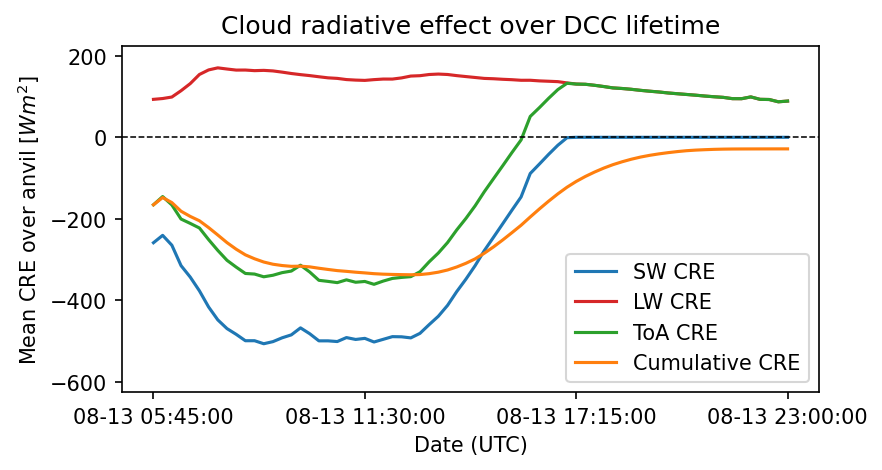

In [5]:
anvil = 9871
core = dataset.core[dataset.core_anvil_index.data==anvil]
wh_core_step = np.isin(dataset.core_step_core_index.data, core)
wh_thick_anvil_step = np.isin(dataset.thick_anvil_step_anvil_index.data, anvil)
wh_thin_anvil_step = np.isin(dataset.thin_anvil_step_anvil_index.data, anvil)


plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(-dataset.thick_anvil_step_toa_swup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C0")
plt.plot(-dataset.thick_anvil_step_toa_lwup_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C3")
plt.plot(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil], "C2")

cumulative_forcing = np.cumsum(dataset.thick_anvil_step_toa_cre_mean[dataset.thick_anvil_step_anvil_index==anvil] * dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
cumulative_forcing /= np.cumsum(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil])
plt.plot(cumulative_forcing, "C1")

plt.legend(["SW CRE", "LW CRE", "ToA CRE", "Cumulative CRE"])

plt.ylabel("Mean CRE over anvil [$Wm^2$]")
plt.xlabel("Date (UTC)")

ax.axhline(y=0, color='k', linestyle="--", linewidth=0.75)

core_dt = dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil].to_series().dt.to_pydatetime()
core_time_str = [str(dt)[-14:] for dt in core_dt]
n_time_steps = len(core_time_str)

plt.ylim([-625,225])
plt.xticks(range(0, n_time_steps, int(np.floor(n_time_steps/3))), core_time_str[::int(np.floor(n_time_steps/3))])

plt.title('Cloud radiative effect over DCC lifetime')

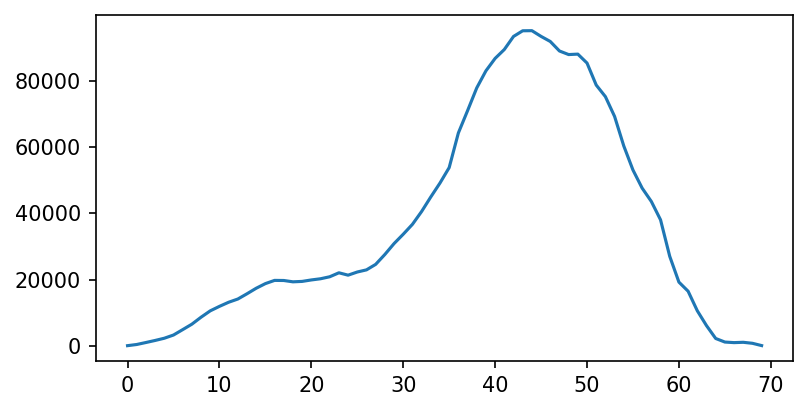

In [6]:
plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(dataset.thick_anvil_step_area[dataset.thick_anvil_step_anvil_index==anvil], "C0")


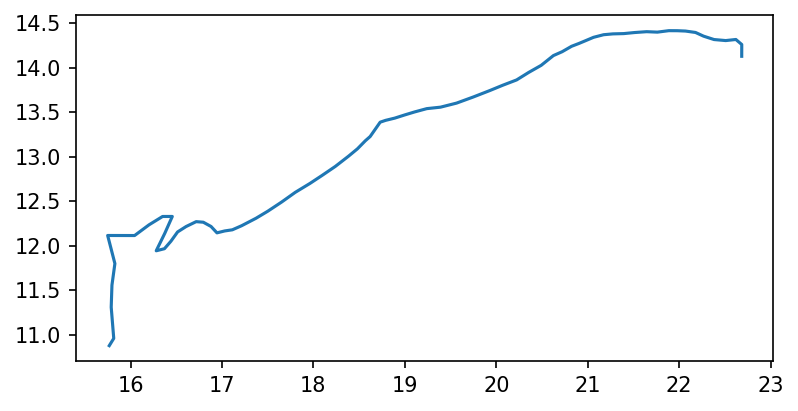

In [7]:
plt.figure(dpi=150, figsize=(6,3))

ax = plt.subplot(111)

plt.plot(dataset.thick_anvil_step_lon[wh_thick_anvil_step], dataset.thick_anvil_step_lat[wh_thick_anvil_step], "C0")


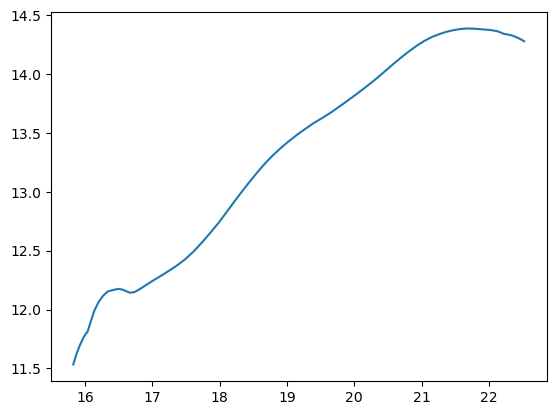

In [8]:
rolling_steps=12

smooth_lat = dataset.thick_anvil_step_lat[wh_thick_anvil_step].rolling(thick_anvil_step=rolling_steps, center=True, min_periods=3).reduce(np.nanmean) 
smooth_lon = dataset.thick_anvil_step_lon[wh_thick_anvil_step].rolling(thick_anvil_step=rolling_steps, center=True, min_periods=3).reduce(np.nanmean)

plt.plot(smooth_lon, smooth_lat)


In [9]:
smooth_area = dataset.thick_anvil_step_area[wh_thick_anvil_step].rolling(thick_anvil_step=rolling_steps, center=True, min_periods=3).reduce(np.nanmean)


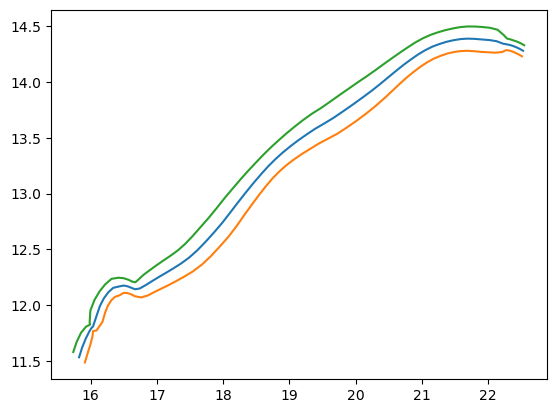

In [10]:
plt.plot(smooth_lon, smooth_lat)
plt.plot(smooth_lon-np.gradient(smooth_lat), smooth_lat+np.gradient(smooth_lon))
plt.plot(smooth_lon+np.gradient(smooth_lat), smooth_lat-np.gradient(smooth_lon))


In [11]:
grad = np.stack([-np.gradient(smooth_lat), np.gradient(smooth_lon)])
grad /= (np.sum(grad**2, 0)**0.5)


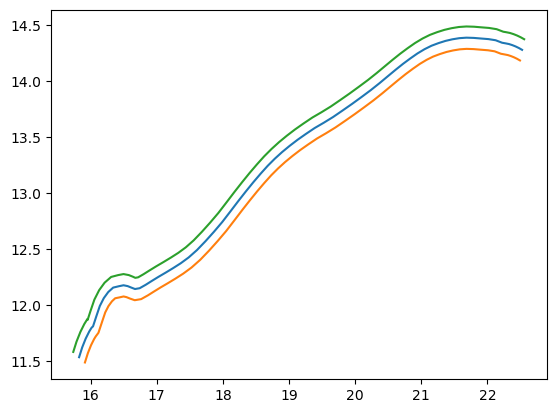

In [12]:
plt.plot(smooth_lon, smooth_lat)
plt.plot(smooth_lon+grad[0]/10, smooth_lat+grad[1]/10)
plt.plot(smooth_lon-grad[0]/10, smooth_lat-grad[1]/10)


In [13]:
offsets = np.log10(smooth_area.data/1000) * grad / 10

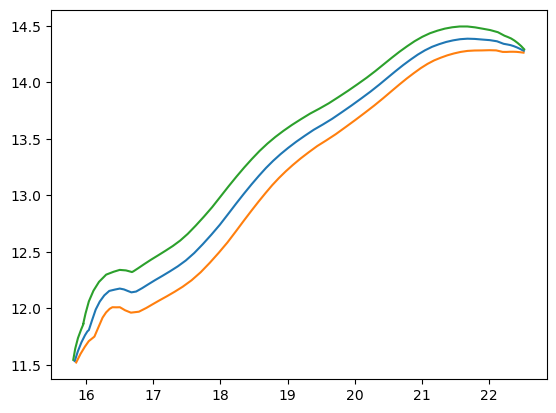

In [14]:
plt.plot(smooth_lon, smooth_lat)
plt.plot(smooth_lon+offsets[0], smooth_lat+offsets[1])
plt.plot(smooth_lon-offsets[0], smooth_lat-offsets[1])


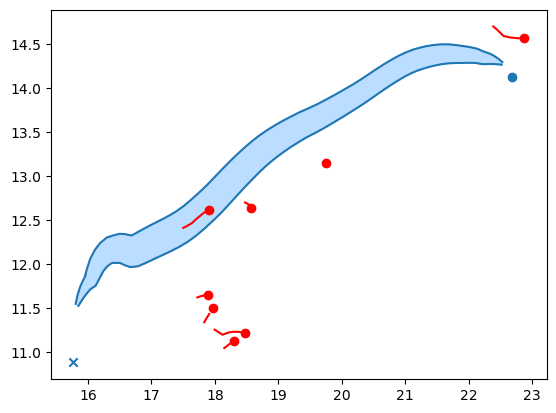

In [15]:
xf = np.concatenate([smooth_lon+offsets[0], (smooth_lon-offsets[0])[::-1]])
yf = np.concatenate([smooth_lat+offsets[1], (smooth_lat-offsets[1])[::-1]])

plt.figure()
ax = plt.subplot(111)

ax.plot(smooth_lon+offsets[0], smooth_lat+offsets[1], "C0")
ax.plot(smooth_lon-offsets[0], smooth_lat-offsets[1], "C0")
ax.fill(xf, yf, color='dodgerblue', alpha=0.3)
ax.scatter(
    dataset.thick_anvil_start_lon.loc[anvil], 
    dataset.thick_anvil_start_lat.loc[anvil], 
    c="C0"
)
ax.scatter(
    dataset.thick_anvil_end_lon.loc[anvil], 
    dataset.thick_anvil_end_lat.loc[anvil], 
    c="C0", marker="x"
)

ax.scatter(dataset.core_start_lon.loc[core], dataset.core_start_lat.loc[core], c="r")
for c in core:
    ax.plot(
        dataset.core_step_lon[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        dataset.core_step_lat[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        "r-"
    )

In [16]:
dataset.core_step_lon[dataset.core_step_core_index==c]

<xarray.DataArray 'core_step_lon' (core_step: 3)>
[3 values with dtype=float32]
Coordinates:
  * core_step  (core_step) int32 85428 85521 85610
    core       int64 17696
Attributes:
    standard_name:  core_step_lon
    long_name:      longitude of core at time step

In [17]:
anvil_cre = dataset.thick_anvil_step_toa_cre_mean[wh_thick_anvil_step]

In [18]:
anvil_cre

<xarray.DataArray 'thick_anvil_step_toa_cre_mean' (thick_anvil_step: 70)>
[70 values with dtype=float32]
Coordinates:
  * thick_anvil_step  (thick_anvil_step) int32 74599 74647 74695 ... 81983 82043
Attributes:
    standard_name:  thick_anvil_step_toa_cre_mean
    long_name:      Mean of toa_cre for each thick_anvil_step

In [19]:
def strfdelta(tdelta, fmt='{D:02}d {H:02}h {M:02}m {S:02}s', inputtype='timedelta'):
    """Convert a datetime.timedelta object or a regular number to a custom-
    formatted string, just like the stftime() method does for datetime.datetime
    objects.

    The fmt argument allows custom formatting to be specified.  Fields can 
    include seconds, minutes, hours, days, and weeks.  Each field is optional.

    Some examples:
        '{D:02}d {H:02}h {M:02}m {S:02}s' --> '05d 08h 04m 02s' (default)
        '{W}w {D}d {H}:{M:02}:{S:02}'     --> '4w 5d 8:04:02'
        '{D:2}d {H:2}:{M:02}:{S:02}'      --> ' 5d  8:04:02'
        '{H}h {S}s'                       --> '72h 800s'

    The inputtype argument allows tdelta to be a regular number instead of the  
    default, which is a datetime.timedelta object.  Valid inputtype strings: 
        's', 'seconds', 
        'm', 'minutes', 
        'h', 'hours', 
        'd', 'days', 
        'w', 'weeks'
    """
    from string import Formatter
    
    # Convert tdelta to integer seconds.
    if inputtype == 'timedelta':
        remainder = int(tdelta.total_seconds())
    elif inputtype in ['s', 'seconds']:
        remainder = int(tdelta)
    elif inputtype in ['m', 'minutes']:
        remainder = int(tdelta)*60
    elif inputtype in ['h', 'hours']:
        remainder = int(tdelta)*3600
    elif inputtype in ['d', 'days']:
        remainder = int(tdelta)*86400
    elif inputtype in ['w', 'weeks']:
        remainder = int(tdelta)*604800

    f = Formatter()
    desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]
    possible_fields = ('W', 'D', 'H', 'M', 'S')
    constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
    values = {}
    for field in possible_fields:
        if field in desired_fields and field in constants:
            values[field], remainder = divmod(remainder, constants[field])
    return f.format(fmt, **values)

In [20]:
strfdelta(timedelta(hours=36), "T+{D}d {H:02}:{M:02}:{S:02}")

'T+1d 12:00:00'

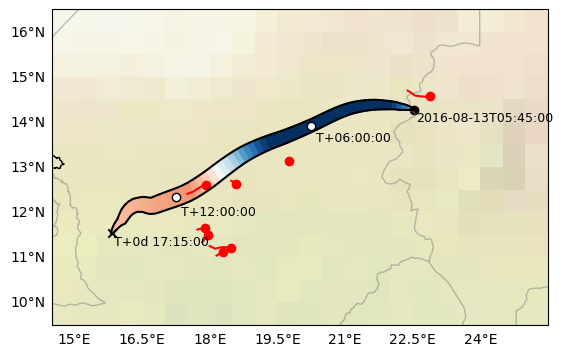

In [24]:
markersize=6
fontsize=9

plt.figure()
ax = plt.subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([14.5, 25.5, 9.5, 16.5], ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.plot(smooth_lon+offsets[0], smooth_lat+offsets[1], "k")
ax.plot(smooth_lon-offsets[0], smooth_lat-offsets[1], "k")

args = []
for i in range(smooth_lon.size-1):
    xf = np.concatenate(
        [smooth_lon[i:i+2]+offsets[0,i:i+2], (smooth_lon[i:i+2]-offsets[0,i:i+2])[::-1]]
    )
    yf = np.concatenate(
        [smooth_lat[i:i+2]+offsets[1,i:i+2], (smooth_lat[i:i+2]-offsets[1,i:i+2])[::-1]]
    )
    cf = plt.cm.RdBu_r(np.maximum(np.minimum(anvil_cre[i].item()+300, 600), 0)/600)
    args.append([xf, yf, cf])

for arg in args:
    ax.fill(arg[0], arg[1], color=arg[2])
ax.scatter(
    smooth_lon[0].item(), 
    smooth_lat[0].item(), 
    c="k", s=markersize**2
)
ax.scatter(
    smooth_lon[-1].item(), 
    smooth_lat[-1].item(), 
    c="k", marker="x", s=markersize**2
)
start_dt = pd.to_datetime(dataset.thick_anvil_start_t.loc[anvil].data).to_pydatetime()
end_dt = pd.to_datetime(dataset.thick_anvil_end_t.loc[anvil].data).to_pydatetime()
lifetime = end_dt - start_dt
ax.text(
    smooth_lon[0].item()+0.05, 
    smooth_lat[0].item()-0.05, 
    start_dt.isoformat(), 
    va="top", fontsize=fontsize
)
ax.text(
    smooth_lon[-1].item()+0.05, 
    smooth_lat[-1].item()-0.05, 
    strfdelta(lifetime, "T+{D}d {H:02}:{M:02}:{S:02}"), 
    va="top", fontsize=fontsize
)

if lifetime.seconds/3600 > 13:
    time_ticks = [timedelta(hours=i) for i in np.arange(6, lifetime.seconds/3600-0.99, 6)]
elif lifetime.seconds/3600 > 4:
    time_ticks = [timedelta(hours=i) for i in np.arange(3, lifetime.seconds/3600-0.99, 3)]
else:
    time_ticks = []
    
if len(time_ticks) > 0 and time_ticks[-1].days >= 1:
    fmtstr = "T+{D}d {H:02}:{M:02}:{S:02}"
else:
    fmtstr = "T+{H:02}:{M:02}:{S:02}"

for time in time_ticks:
    wh = np.abs(
        dataset.thick_anvil_step_t[dataset.thick_anvil_step_anvil_index==anvil] 
        - np.datetime64(start_dt+time)
    ).argmin().item()
    
    ax.scatter(smooth_lon[wh], smooth_lat[wh], marker="o", s=markersize**2, facecolor="white", edgecolor="k")
    
    ax.text(smooth_lon[wh]+offsets[0][wh]+0.05, smooth_lat[wh]+offsets[1][wh], strfdelta(time, fmtstr), va="top", fontsize=fontsize)


ax.scatter(dataset.core_start_lon.loc[core], dataset.core_start_lat.loc[core], c="r")
for c in core:
    ax.plot(
        dataset.core_step_lon[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        dataset.core_step_lat[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
        "r-"
    )

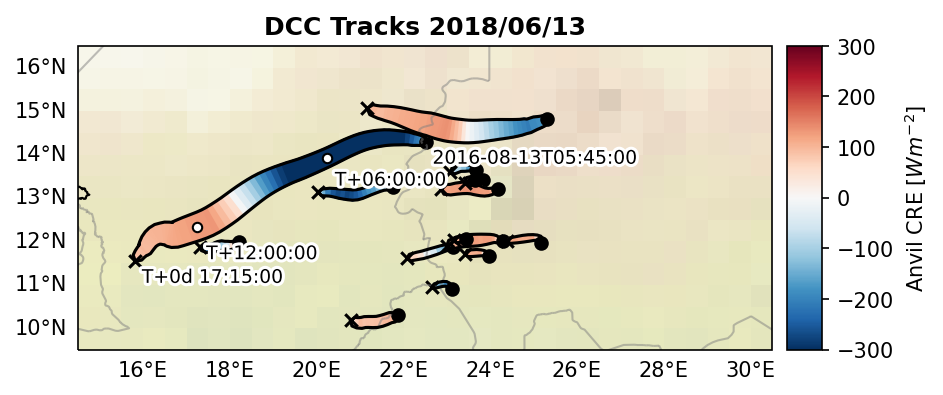

In [34]:
def add_anvil_track(dataset, anvil, ax, annotate=False):
    markersize=6
    fontsize=9
    
    wh_thick_anvil_step = np.isin(dataset.thick_anvil_step_anvil_index.data, anvil)
    n_steps = np.sum(wh_thick_anvil_step)
    rolling_steps = np.minimum(np.maximum(n_steps//4, 3), 12)
    
    smooth_lat = dataset.thick_anvil_step_lat[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean) 
    smooth_lon = dataset.thick_anvil_step_lon[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean)
    smooth_area = dataset.thick_anvil_step_area[wh_thick_anvil_step].rolling(
        thick_anvil_step=rolling_steps, center=True, min_periods=1
    ).reduce(np.nanmean)
    anvil_cre = dataset.thick_anvil_step_toa_cre_mean[wh_thick_anvil_step]
    
    grad = np.stack([-np.gradient(smooth_lat), np.gradient(smooth_lon)])
    grad /= (np.sum(grad**2, 0)**0.5)
    offsets = 2**np.log10(smooth_area.data / 1000) * grad / 12
    offsets[:, 0] = 0
    offsets[:, -1] = 0
    
    ax.plot(smooth_lon+offsets[0], smooth_lat+offsets[1], "k")
    ax.plot(smooth_lon-offsets[0], smooth_lat-offsets[1], "k")

    args = []
    for i in range(smooth_lon.size-1):
        xf = np.concatenate(
            [smooth_lon[i:i+2]+offsets[0,i:i+2], (smooth_lon[i:i+2]-offsets[0,i:i+2])[::-1]]
        )
        yf = np.concatenate(
            [smooth_lat[i:i+2]+offsets[1,i:i+2], (smooth_lat[i:i+2]-offsets[1,i:i+2])[::-1]]
        )
        cf = plt.cm.RdBu_r(np.maximum(np.minimum(anvil_cre[i].item()+300, 600), 0)/600)
        args.append([xf, yf, cf])

    for arg in args:
        ax.fill(arg[0], arg[1], color=arg[2])
    ax.scatter(
        smooth_lon[0].item(), 
        smooth_lat[0].item(), 
        c="k", s=markersize**2
    )
    ax.scatter(
        smooth_lon[-1].item(), 
        smooth_lat[-1].item(), 
        c="k", marker="x", s=markersize**2
    )
    start_dt = pd.to_datetime(dataset.thick_anvil_start_t.loc[anvil].data).to_pydatetime()
    end_dt = pd.to_datetime(dataset.thick_anvil_end_t.loc[anvil].data).to_pydatetime()
    lifetime = end_dt - start_dt
    
    if annotate:
        ax.text(
            smooth_lon[0].item()+0.15, 
            smooth_lat[0].item()-0.15, 
            start_dt.isoformat(), 
            va="top", fontsize=fontsize, 
            path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
        )
        ax.text(
            smooth_lon[-1].item()+0.15, 
            smooth_lat[-1].item()-0.15, 
            strfdelta(lifetime, "T+{D}d {H:02}:{M:02}:{S:02}"), 
            va="top", fontsize=fontsize, 
            path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
        )
    
        if lifetime.total_seconds()/3600 > 13:
            time_ticks = [timedelta(hours=i) for i in np.arange(6, lifetime.total_seconds()/3600-0.99, 6)]
        elif lifetime.total_seconds()/3600 > 4:
            time_ticks = [timedelta(hours=i) for i in np.arange(3, lifetime.total_seconds()/3600-0.99, 3)]
        else:
            time_ticks = []
        
        if len(time_ticks) > 0 and time_ticks[-1].days >= 1:
            fmtstr = "T+{D}d {H:02}:{M:02}:{S:02}"
        else:
            fmtstr = "T+{H:02}:{M:02}:{S:02}"

        for time in time_ticks:
            wh = np.abs(
                dataset.thick_anvil_step_t[wh_thick_anvil_step] 
                - np.datetime64(start_dt+time)
            ).argmin().item()

            ax.scatter(
                smooth_lon[wh], smooth_lat[wh], marker="o", 
                s=(markersize*0.75)**2, facecolor="white", edgecolor="k"
            )
            
            ax.text(
                smooth_lon[wh]+offsets[0][wh]+0.1, smooth_lat[wh]+offsets[1][wh]-0.1, 
                strfdelta(time, fmtstr), 
                va="top", fontsize=fontsize, 
                path_effects=[patheffects.withStroke(linewidth=3, foreground="w")]
            )


fig = plt.figure(dpi=150)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
img_extent = [14.5, 30.5, 9.5, 16.5]
ax.set_extent(img_extent, ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_valid_anvil = np.logical_and.reduce(
    [
        dataset.thick_anvil_start_lon.data > img_extent[0]+0.5,
        dataset.thick_anvil_end_lon.data > img_extent[0]+0.5,
        dataset.thick_anvil_start_lon.data < img_extent[1]-0.5,
        dataset.thick_anvil_end_lon.data < img_extent[1]-0.5,
        dataset.thick_anvil_start_lat.data > img_extent[2]+0.5,
        dataset.thick_anvil_end_lat.data > img_extent[2]+0.5,
        dataset.thick_anvil_start_lat.data < img_extent[3]-0.5,
        dataset.thick_anvil_end_lat.data < img_extent[3]-0.5,
        dataset.thick_anvil_start_t.data >= np.datetime64(datetime(2016,8,13)), 
        dataset.thick_anvil_end_t.data <= np.datetime64(datetime(2016,8,14))
    ]
)

anvils = dataset.anvil.data[wh_valid_anvil]

for anv in anvils:
    add_anvil_track(dataset, anv, ax, annotate=(anv==9871))

plt.title("DCC Tracks 2018/06/13", fontweight="bold")

cbar_size="5%"
cbar_pad=0.1
ax_divider = make_axes_locatable(ax)
cax_r = ax_divider.new_horizontal(size=cbar_size, pad=cbar_pad, axes_class=plt.Axes)
fig.add_axes(cax_r)

norm = colors.Normalize(vmin=-300,vmax=300)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax_r, label="Anvil CRE [$Wm^{-2}$]")


In [32]:
anvils

array([ 9778,  9848,  9854,  9871,  9994, 10158, 10177, 10242, 10259,
       10422, 10442, 10484, 10507, 10508, 10539])

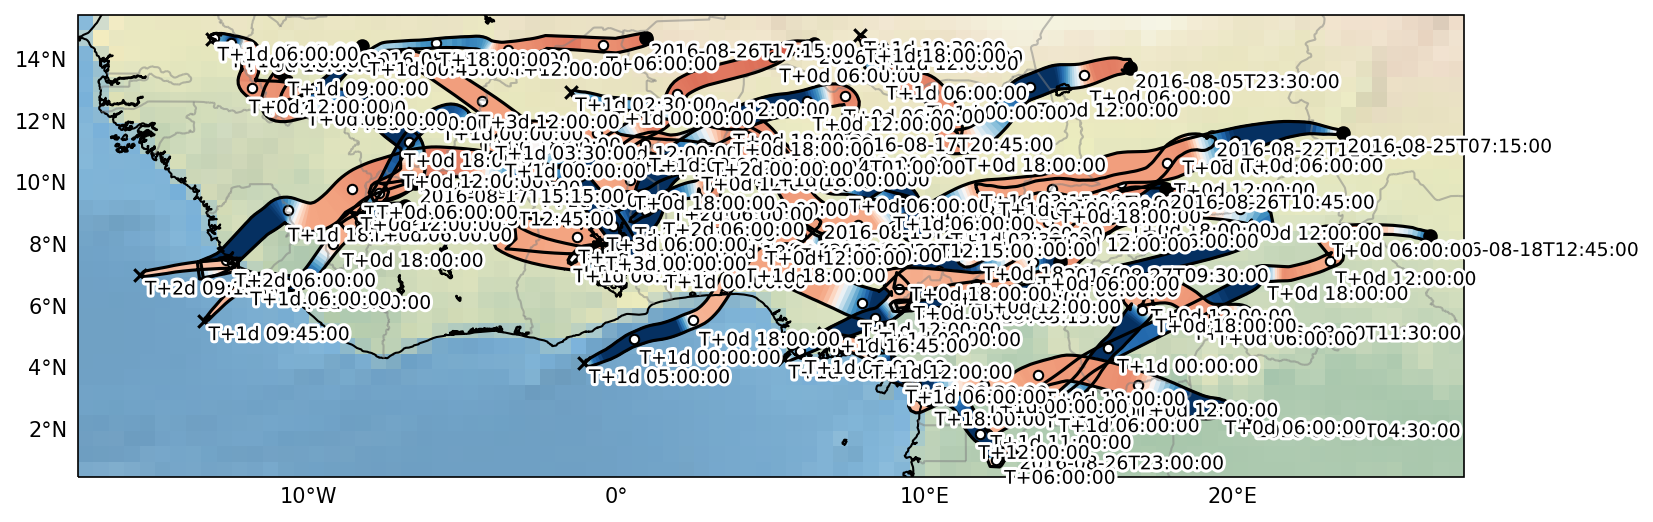

In [28]:
plt.figure(figsize=(12,4), dpi=150)
ax = plt.subplot(111, projection=ccrs.PlateCarree())
img_extent = (-17.5, 27.5, 0.5, 15.5)
ax.set_extent(img_extent, ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, edgecolor='gray', alpha=0.5)
ax.add_feature(cfeature.LAKES, edgecolor='black', alpha=1, facecolor="none")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

wh_valid_anvil = np.logical_and.reduce(
    [
        dataset.thick_anvil_start_lon.data > img_extent[0]+0.5,
        dataset.thick_anvil_end_lon.data > img_extent[0]+0.5,
        dataset.thick_anvil_start_lon.data < img_extent[1]-0.5,
        dataset.thick_anvil_end_lon.data < img_extent[1]-0.5,
        dataset.thick_anvil_start_lat.data > img_extent[2]+0.5,
        dataset.thick_anvil_end_lat.data > img_extent[2]+0.5,
        dataset.thick_anvil_start_lat.data < img_extent[3]-0.5,
        dataset.thick_anvil_end_lat.data < img_extent[3]-0.5,
#         dataset.thick_anvil_start_t.data >= np.datetime64(datetime(2016,8,1)), 
#         dataset.thick_anvil_end_t.data <= np.datetime64(datetime(2016,8,14)), 
        dataset.thick_anvil_lifetime.data >= np.timedelta64(timedelta(hours=24))
    ]
)

anvils = dataset.anvil.data[wh_valid_anvil]

for anv in anvils:
    add_anvil_track(dataset, anv, ax)

# ax.scatter(dataset.core_start_lon.loc[core], dataset.core_start_lat.loc[core], c="r")
# for c in core:
#     ax.plot(
#         dataset.core_step_lon[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
#         dataset.core_step_lat[dataset.core_step_core_index==c].rolling(core_step=3, center=True, min_periods=1).reduce(np.nanmean), 
#         "r-"
#     )

array([3953, 4283, 7791, 7846])